# Meta Methods applied to the ionosphere data set

In [52]:
import l
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    AdaBoostClassifier, 
    BaggingClassifier, 
    ExtraTreesClassifier,
    GradientBoostingClassifier, 
    RandomForestClassifier,
    VotingClassifier,
)


import  matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)  # To ignore warnings due to deprecated functions

%matplotlib inline

In [53]:

# Load the original and encoded datasets
df_original = pd.read_csv("preprocessed.csv", header=None, low_memory=False)
df_encoded = pd.read_csv("preprocessed_encoded.csv", header=None, low_memory=False)

# Extract the 'match' column from the original dataset
match_column = df_original.iloc[:, -1]

# Append the 'match' column to the encoded dataset
df_encoded = pd.concat([df_encoded, match_column.rename('match')], axis=1)

# Convert all columns to numeric, coercing errors to handle non-numeric gracefully
df_encoded = df_encoded.apply(pd.to_numeric, errors='coerce')

# Drop rows with any non-numeric values that couldn't be coerced
df_encoded = df_encoded.dropna()

# Extract features and target variable
y = df_encoded['match'].values
X = df_encoded.drop(columns=['match']).values



# Inspect the first few rows
df_encoded.head()


,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,match
1,1.0,21.0,27.0,6.0,2.0,4.0,35.0,20.0,20.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,21.0,22.0,1.0,2.0,4.0,60.0,0.0,0.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,21.0,22.0,1.0,2.0,4.0,19.0,18.0,19.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,21.0,23.0,2.0,2.0,4.0,30.0,5.0,15.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,21.0,24.0,3.0,2.0,4.0,30.0,10.0,20.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Voting scheme

In [54]:
# The dataset is divided into k subsets or folds
cv = 30

clf1 = GaussianNB()

params = {
    "n_neighbors": list(range(1,30,2)), 
    "weights": ("distance", "uniform")
}
knc = KNeighborsClassifier()
clf = GridSearchCV(
    knc, 
    param_grid = params,
    cv = cv,
    n_jobs = -1
)
clf.fit(X, y)
print(f"Best Params fo Knn = {clf.best_params_}  -  Accuracy = {clf.best_score_}")

parval = clf.best_params_
clf2 = KNeighborsClassifier(
    n_neighbors = parval["n_neighbors"],
    weights = parval["weights"]
)

clf3 = DecisionTreeClassifier(criterion = "entropy")

for clf, label in zip([clf1, clf2, clf3], ['Naive Bayes','Knn (3)', 'Dec. Tree', ]):
    scores = cross_val_score(
        clf, 
        X, 
        y, 
        cv = cv, 
        scoring = "accuracy"
    )

    print("Accuracy: %0.3f [%s]" % (scores.mean(), label))  # TODO: update this part
   

Best Params fo Knn = {'n_neighbors': 29, 'weights': 'uniform'}  -  Accuracy = 0.8303878648233488
Accuracy: 0.177 [Naive Bayes]
Accuracy: 0.830 [Knn (3)]
Accuracy: 0.779 [Dec. Tree]


In [55]:
eclf = VotingClassifier(
    estimators=[
        ("nb", clf1), 
        ("knn3", clf2), 
        ("dt", clf3)
    ],
    voting = "hard")
scores = cross_val_score(
    eclf, 
    X, 
    y, 
    cv = cv, 
    scoring = "accuracy"
)
print("Accuracy: %0.3f [%s]" % (scores.mean() , "Majority Voting"))  # TODO: update this part

Accuracy: 0.771 [Majority Voting]


In [56]:
eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)],voting='soft', weights=[2,1,2])
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Accuracy: 0.771 [Weighted Voting]


## Bagging

In [57]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

"""
lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        BaggingClassifier(
            base_estimator = DecisionTreeClassifier(),
            n_estimators = nest
        ), 
        X, 
        y, 
        cv = cv, 
        scoring = "accuracy"
    )
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb.append(scores.mean())

lb2=[]    
print()
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        BaggingClassifier(
            base_estimator = DecisionTreeClassifier(),
            n_estimators = nest,
            max_features = 0.35
        ), 
        X, 
        y, 
        cv = cv, 
        scoring = "accuracy"
    )
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb2.append(scores.mean())
    
"""
from sklearn.ensemble import VotingClassifier, BaggingClassifier

# Define the voting classifier with corrected parameters
eclf = VotingClassifier(
    estimators=[
        ("nb", clf1), 
        ("knn3", clf2), 
        ("dt", clf3)
    ],
    voting="hard"
)

# Define a dictionary of metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, average='macro', multi_class='ovr')
}

# Evaluate and print scores for the voting classifier
print("Voting Classifier (Hard Voting):")
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(
        eclf, 
        X, 
        y, 
        cv=cv, 
        scoring=metric
    )
    print(f"{metric_name.capitalize()}: {scores.mean():.3f} ± {scores.std():.3f}")

# Example for BaggingClassifier with corrected parameter
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=10,
    random_state=0
)

# Evaluate and print scores for the bagging classifier
print("\nBagging Classifier with Decision Trees:")
for metric_name, metric in scoring_metrics.items():
    scores = cross_val_score(
        bagging_clf, 
        X, 
        y, 
        cv=cv, 
        scoring=metric
    )
    print(f"{metric_name.capitalize()}: {scores.mean():.3f} ± {scores.std():.3f}")


Voting Classifier (Hard Voting):
Accuracy: 0.770 ± 0.034
Precision: 0.584 ± 0.054
Recall: 0.582 ± 0.062
F1: 0.579 ± 0.055
Roc_auc: 0.587 ± 0.064

Bagging Classifier with Decision Trees:
Accuracy: 0.824 ± 0.035
Precision: 0.669 ± 0.083
Recall: 0.590 ± 0.039
F1: 0.605 ± 0.048
Roc_auc: 0.590 ± 0.039


## Random Forest

In [58]:
lrf = []
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(RandomForestClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lrf.append(scores.mean())

Accuracy: 0.743 [1]
Accuracy: 0.817 [2]
Accuracy: 0.806 [5]
Accuracy: 0.823 [10]
Accuracy: 0.830 [20]
Accuracy: 0.833 [50]
Accuracy: 0.836 [100]
Accuracy: 0.835 [200]


In [59]:
lext = []
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        ExtraTreesClassifier(n_estimators = nest), 
        X, 
        y, 
        cv = cv, 
        scoring = "accuracy"
    )
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lext.append(scores.mean())

Accuracy: 0.723 [1]
Accuracy: 0.799 [2]
Accuracy: 0.776 [5]
Accuracy: 0.804 [10]
Accuracy: 0.804 [20]
Accuracy: 0.805 [50]
Accuracy: 0.804 [100]
Accuracy: 0.804 [200]


## Boosting

In [60]:
lboo = []
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        AdaBoostClassifier(n_estimators = nest), 
        X, 
        y, 
        cv = cv, 
        scoring = "accuracy"
    )
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboo.append(scores.mean())

/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.835 [1]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.835 [2]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.841 [5]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.846 [10]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.849 [20]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.821 [50]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.792 [100]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.762 [200]


In [61]:
lboodt = []
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        AdaBoostClassifier(
            DecisionTreeClassifier(max_depth = 5),
            n_estimators = nest
        ), 
        X,
        y, 
        cv = cv, 
        scoring = "accuracy"
    )
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboodt.append(scores.mean())

/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.836 [1]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.835 [2]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.813 [5]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.783 [10]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.782 [20]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.761 [50]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.769 [100]


/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/w/hustlin/learn py/MD_D1_3_12/newvenv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default)

Accuracy: 0.790 [200]


In [66]:
lgbboo = []
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(
        GradientBoostingClassifier(n_estimators = nest), 
        X, 
        y, 
        cv = cv, 
        scoring = "accuracy"
    )
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))  # TODO: transform into f-string
    lgbboo.append(scores.mean())
print(lgbboo)

Accuracy: 0.835 [1]
Accuracy: 0.835 [2]
Accuracy: 0.835 [5]
Accuracy: 0.839 [10]
Accuracy: 0.854 [20]
Accuracy: 0.842 [50]
Accuracy: 0.825 [100]
Accuracy: 0.802 [200]
[0.8352824714115036, 0.8352824714115036, 0.8352824714115036, 0.8393399044205496, 0.8536627410820959, 0.8422183819764464, 0.8251467827274279, 0.8023425499231952]


In [77]:
lb = []

for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    scores = cross_val_score(
        BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=nest), 
        X, 
        y, 
        cv=cv, 
        scoring="accuracy"
    )
    print(f"Accuracy: {scores.mean():.3f} [{nest}]")
    lb.append(scores.mean())

Accuracy: 0.767 [1]
Accuracy: 0.821 [2]
Accuracy: 0.810 [5]
Accuracy: 0.823 [10]
Accuracy: 0.831 [20]
Accuracy: 0.830 [50]
Accuracy: 0.832 [100]
Accuracy: 0.833 [200]


In [71]:
l =[]

for nest in [1, 2, 5, 10, 20, 50, 100, 200]:
    scores = cross_val_score(
        BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=nest, max_features=0.35), 
        X, 
        y, 
        cv=cv, 
        scoring="accuracy"
    )
    print(f"Accuracy: {scores.mean():.3f} [{nest}]")
    l.append(scores.mean())

Accuracy: 0.728 [1]
Accuracy: 0.812 [2]
Accuracy: 0.800 [5]
Accuracy: 0.822 [10]
Accuracy: 0.829 [20]
Accuracy: 0.833 [50]
Accuracy: 0.836 [100]
Accuracy: 0.833 [200]


In [106]:
print(l)

[0.8349210616146099, 0.8377871650452297, 0.8490036695681857, 0.8394572452636968, 0.8308644819935144, 0.8311030039255846, 0.8522303294077488, 0.8427995391705069, 0.8469785799624509, 0.8443480116060761, 0.8410082778631165, 0.8529420549581839, 0.7792993684929168, 0.8425614439324115, 0.8398143881208397, 0.852110855094726, 0.8404113329919781, 0.8565279911247654, 0.8379062126642773, 0.8343245434374466, 0.8385018774534905, 0.8342059225123741, 0.8343245434374467, 0.8365928486089778, 0.8302666837344258, 0.8302683905103261, 0.8301489161973031, 0.8306263867554191, 0.8311034306195597, 0.8496082949308756, 0.8380256869773, 0.8377863116572795, 0.855814985492405, 0.8404126130739034, 0.854615122034477, 0.8320562382659157, 0.8320566649598908, 0.833847926267281, 0.8307450076804916, 0.8325341355180066, 0.8311042840075099, 0.832773510838027, 0.8316982420208228, 0.8337280252602833, 0.8300298685782558, 0.8324142345110086, 0.8319380440348183, 0.8303870114353986, 0.8330107526881722, 0.830267110428401, 0.833847

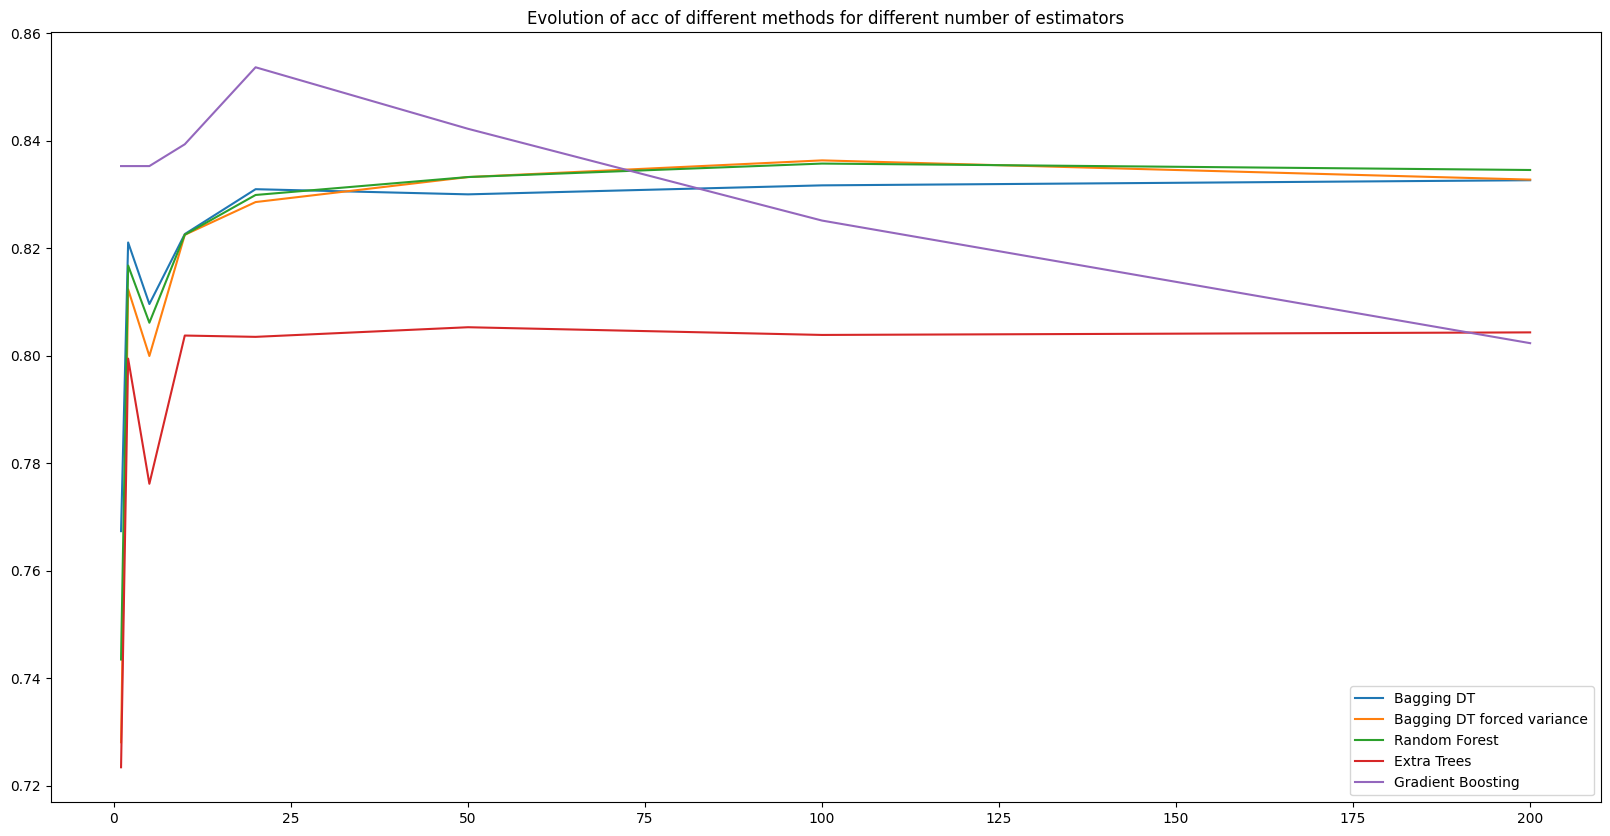

In [79]:
#from scipy.constants import lb

plt.figure(figsize = (20, 10))
plt.title("Evolution of acc of different methods for different number of estimators")
plt.plot([1,2,5,10,20,50,100,200],lb,label = "Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],l,label = "Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label = "Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label = "Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label = "Gradient Boosting")
plt.legend(loc = "lower right")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (8,) and (332,)

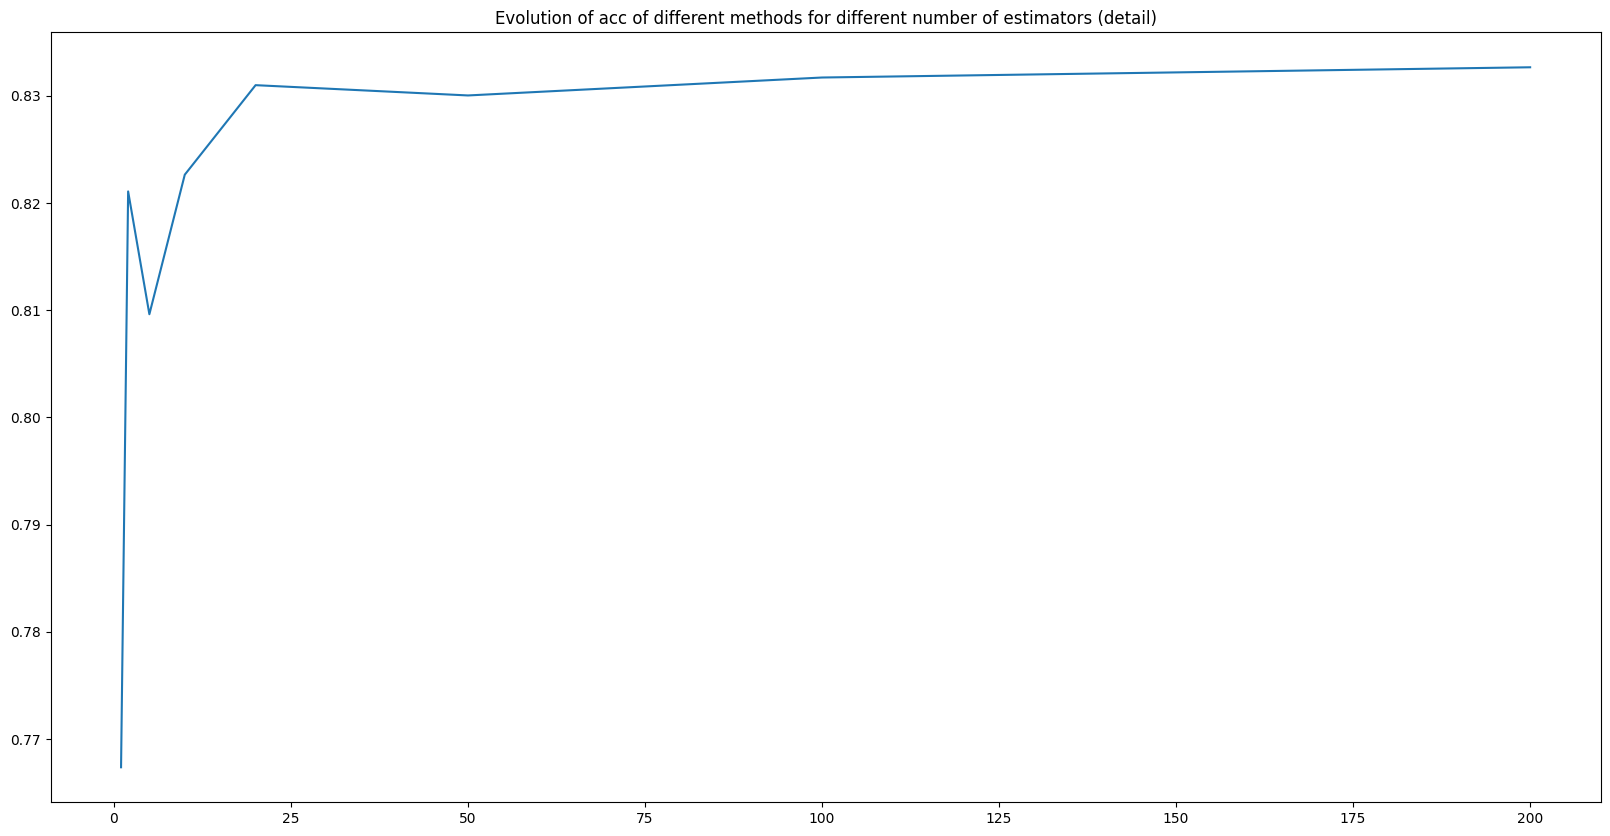

In [104]:
plt.figure(figsize = (20, 10))
plt.title("Evolution of acc of different methods for different number of estimators (detail)")
plt.plot([1,2,5,10,20,50,100,200],lb,label = "Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],l,label = "Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label = "Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label = "Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label = "Gradient Boosting")
plt.legend(loc = "lower right")
#plt.xlim(10,200)
#plt.ylim(0.90,0.96)
plt.show()

## Feature Selection with Forests of trees

In [83]:
clf = RandomForestClassifier(n_estimators = 100)
clf = clf.fit(X, y)
print(clf.feature_importances_)

[1.30674259e-02 1.35017926e-02 1.83393528e-02 1.63814822e-02
 9.88479305e-03 9.31660495e-03 1.99631993e-02 1.74672740e-02
 1.82412389e-02 1.78345561e-02 1.70059229e-02 1.95125545e-02
 4.22228186e-02 1.73405616e-02 1.58190893e-02 3.36862021e-02
 1.60253179e-02 3.29285277e-02 1.42693050e-02 1.28750861e-02
 1.32856683e-02 1.17315805e-02 1.20295983e-02 1.32136314e-02
 9.03516954e-03 7.89995455e-03 8.65757377e-03 7.51989764e-03
 9.28965631e-03 3.50096688e-02 1.35924585e-02 1.39276567e-02
 2.95617189e-02 1.43595928e-02 2.92587542e-02 1.03923163e-02
 1.02777631e-02 1.16916397e-02 8.55080422e-03 1.00567503e-02
 9.69809128e-03 1.11212968e-02 1.02547585e-02 1.14483450e-02
 8.93471985e-03 1.04613452e-02 1.02559884e-02 9.14112330e-03
 1.08471060e-02 9.22307575e-03 1.18114427e-02 1.08809964e-02
 2.37534039e-02 9.49101882e-03 1.45120548e-02 4.02470894e-02
 2.93470897e-02 5.73127067e-03 3.04982411e-03 2.59135592e-03
 3.70911197e-04 2.74377344e-03 1.55943076e-03 3.09043703e-03
 2.03590145e-03 1.556762

In [100]:
from sklearn.feature_selection import SelectFromModel

#lowered treshold to 0.04, because otherwise feature selection is too high, resulting in no features being selected.
model = SelectFromModel(clf, prefit = True, threshold = 0.04)
X_new = model.transform(X)
print(X_new.shape)

print("accuracy before future selection: " + str(np.mean(cross_val_score(KNeighborsClassifier(), X = X, y = y, cv = cv, scoring = "accuracy"))))
print("accuracy after future selection: " + str(np.mean(cross_val_score(KNeighborsClassifier(), X = X_new, y = y, cv = cv, scoring = "accuracy"))))
#print(y)
#print(y[0],y[-1])
#print(X_new)

(8378, 2)
accuracy before future selection: 0.726999061273255
accuracy after future selection: 0.8272857996245093


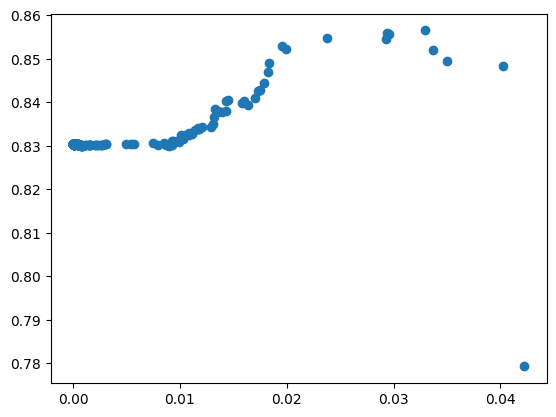

Best threshold: 0.03292852774070956


In [101]:
thresholds = clf.feature_importances_

l=[]
lparval=[]
for threshold in thresholds:
    model = SelectFromModel(
        clf, 
        prefit = True, 
        threshold = threshold
    )
    X_new = model.transform(X)
    params = {
        "n_neighbors": list(range(1,30,2)), 
        "weights": ("distance", "uniform")
    }
    
    knc = KNeighborsClassifier()
    clf2 = GridSearchCV(
        knc, 
        param_grid = params,
        cv = cv,
        n_jobs = -1
    )
    clf2.fit(X, y)
    parval = clf2.best_params_
    clf3 = KNeighborsClassifier(
        n_neighbors = parval["n_neighbors"],
        weights = parval["weights"]
    )
    acc = np.mean(cross_val_score(clf3, X = X_new, y = y, cv = cv, scoring = "accuracy"))
    l.append(acc)
    lparval.append(parval)
    
plt.scatter(thresholds,l)
plt.show()

print(f"Best threshold: {thresholds[np.argmax(l)]}")

In [102]:


parval = lparval[np.argmax(l)]
model = SelectFromModel(
    clf, 
    prefit = True, 
    threshold = thresholds[np.argmax(l)]
)
X_new = model.transform(X)
print(X_new.shape)

original_accuracy = np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X=X, y=y, cv=cv, scoring='accuracy'))

print(f"Original: {original_accuracy}", np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X=X, y=y, cv=cv, scoring='accuracy')))
print("With FS: ", np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights']), X=X_new, y=y, cv=cv, scoring='accuracy')))

(8378, 5)
Original: 0.5943940945553848 0.5943940945553848
With FS:  0.8565279911247654
